# Linear Mixed Effect Modeling


```{note}
This chapter was written by [Todd Gureckis](http://gureckislab.org/~gureckis) who adapted it from Gabriela K. Hajduk and the University of Edinburgh [coding club](https://ourcodingclub.github.io) tutorial on Mixed Effect Linear Models and the [mixed models](https://www.kaggle.com/ojwatson/mixed-models/comments) Kaggle notebook by [OJ Watson](https://www.kaggle.com/ojwatson).  The former is release under CC BY-SA 4.0, the latter under the [Apache 2.0](http://www.apache.org/licenses/LICENSE-2.0) license.  The text is a mashup of these two resources with various editing to connect to the rest of the book for the current class.  The notebook released under the [license](../../LICENSE.html) for the book.
```

The goal in this chapter is to introduce **_linear mixed effect_** modeling (aka LME).  Linear mixed effect models are among the most useful in psychological science.  While previous chapters explore the virtues of linear modeling (e.g., linear regression), this chapter deals with a very common scenario where different observations might fall into various subgroups.  For example, we might have data that are trials in an experiment that are grouped based on which subject they came from.  The subjects might be grouped by which condition of an experiment they were assigned to or how old they are.  Linear mixed effect models are an useful tool for analyzing these types of data because they help to minimize the number of independent tests that are performed across groups (the multiple-comparison problem) while also helping to ensure that the data are not broken into many small groups (lowering power).

In [1]:
# import modules needed
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import sklearn as sk
from math import sqrt
import warnings
warnings.filterwarnings('ignore')

class Caption:
    def __init__(self, fig_no, text, c_type='f'):
        self.fig_no = fig_no
        self.text = text
        if c_type=='t':
            self.c_type = 'Table'
        else:
            self.c_type = 'Figure'
    
    def _repr_html_(self):
        return f"<div class=\"alert alert-info\" role=\"alert\"><b>{ self.c_type } { self.fig_no }</b>. { self.text }</div>"

Matplotlib is building the font cache; this may take a moment.


## An example: Bounce time from a website

Rather than starting with a bunch of equations and terms, let's just start with an intuitive example.  We will start by analyzing a dataset (from Kaggle) that looks at the bounce times of users of a website with cooking recipes. The bounce time is a measure of how quickly someone leaves a website, e.g., the number of seconds after a user first accesses a webpage from the website to the time that they leave. The phrase bounce is like when you are at a party and the cops show up: "let's bounce."   

Most websites want individuals to stay on their websites for a long time as they are more likely to read another article, buy one of their products, click on some of the sponsored links, etc. As such, it can be useful to understand why some users leave the website quicker than others.

To investigate the bounce time of the website, we chose three locations in 8 counties in England, and got members of the public of all ages to undertake a survey/test questionnaire. In the test we asked them to use our search engine to query for something they want to eat this evening. The search engine listed our website first, as well as listing other websites. The users that clicked on our website were then timed and their bounce time recorded. We also recorded their age, and made a note of the county and location.

We have been asked by the website to work out if younger individuals are more likely to leave the website quicker.

Let's begin by reading in the data.

In [2]:
# read in our data
data = pd.read_csv('bounce.csv')
data.head(15)

,bounce_time,age,county,location
0,165.548520,16,devon,a
1,167.559314,34,devon,a
2,165.882952,6,devon,a
3,167.685525,19,devon,a
4,169.959681,34,devon,a
5,168.688747,47,devon,a
6,169.619382,7,devon,a
7,164.416273,8,devon,a
8,167.510430,8,devon,a
9,179.606068,7,devon,a


As we can see, there is the bounce time in seconds, the age of the person, the county they live in, and there is a location code for the place the person was recruited inside the county.  Let's take the approach of kind of exploring the data with descriptive statistics and plots to get a sense of what is going on.

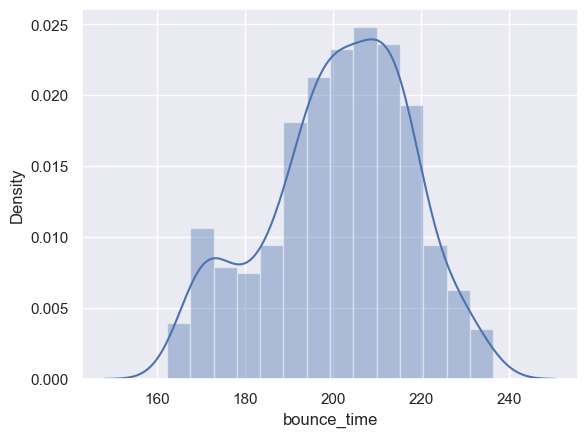

In [3]:
# plot the distribution of the bounce times - this creates the object that will be plotted when matplotlib.pyplot
sns.distplot(data.bounce_time)
plt.show()
display(Caption(1.0, "Histogram showing how many seconds people spent on the website."))

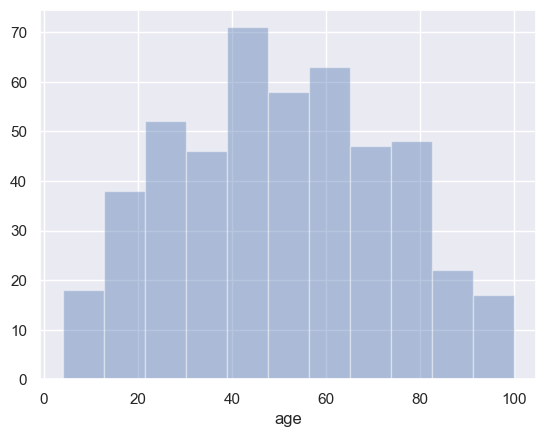

In [4]:
# plot the distribution of the ages
sns.distplot(data.age, kde=False)
plt.show()
display(Caption(2.0, "Histogram showing the ages of people who took part in the marketing study."))

Before we carry on it is often a good idea to **scale** our independent (explanatory) variables so that they are **standardized**. This is useful as it means that any estimated coefficients from our regression model later on are all on the same scale. So, for our dataset this would be the age, and let's create a new variable called **age_scaled**, which is the age scaled to have zero mean and unit variance (the $z$-score):

In [5]:
# lets use the scale function from the preprocess package within sklearn
from sklearn import preprocessing
data["age_scaled"] = preprocessing.scale(data.age.values)

We discussed $z$-scores in a previous chapter including how to compute them in python.  Here we use the scikit-learn package, a machine learning toolkit, which has a helpful scaling function built-in ([see here for full documentation](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html)).

This scaling won't impact the statistical findings in our example but you may find, in more complex models than the one in this tutorial, that this can be very helpful in speeding up your model fitting. It also makes comparison between a continous variable like age, and a binary variable (0, 1) more fair.

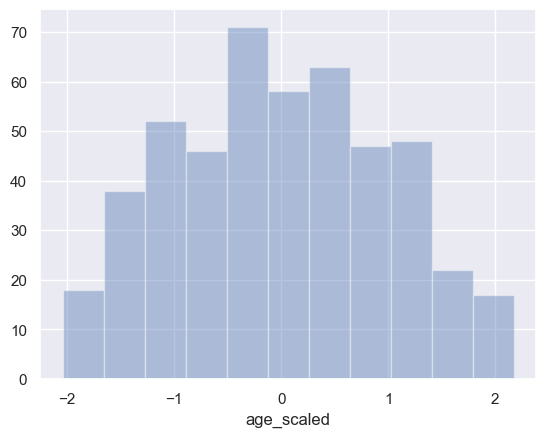

In [6]:
# plot the scaled distribution
sns.distplot(data.age_scaled, kde=False)
plt.show()
display(Caption(3.0, "Histogram showing the z-scored ages of people who took part in the marketing study."))

## Simple Linear Regression

One thing we might want to do to see if the bounce time is dependent on age is to plot these data, and then fit a linear regression to the data:

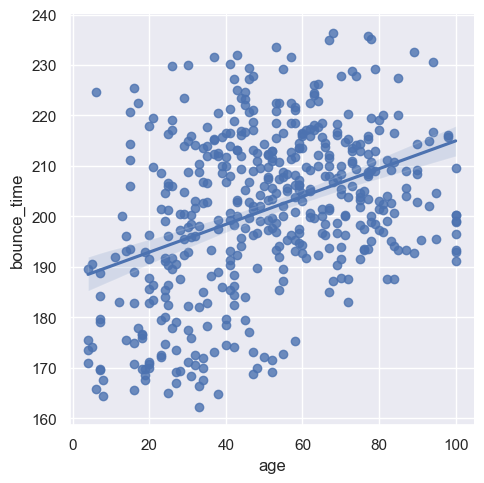

In [7]:
# let's use the lmplot function within seaborn
sns.lmplot(x = "age", y = "bounce_time", data = data)

It would seem, from this simple analysis that older people do spend a longer amount of time on the website. To go into this further let's look at the coefficient estimates from our linear model. 

### Quick Review of Simple Linear Regression

We will start with the most familiar linear regression, a straight-line fit to data.
A straight-line fit is a model of the form

$$
y = b_0 + b_1x 
$$

where $b_1$ is commonly known as the *gradient*, and $b_0$ is commonly known as the *intercept*. So for our dataset, `y` would be the bounce time, `x` their age, `b_1` the rate of change of the bounce time with respect to `age` and `b_0` the intercept when `age` is 0.

$$
time = b_0 + b_1age
$$

We can use Scikit-Learn's ``LinearRegression`` estimator to fit these data and construct the best-fit line:

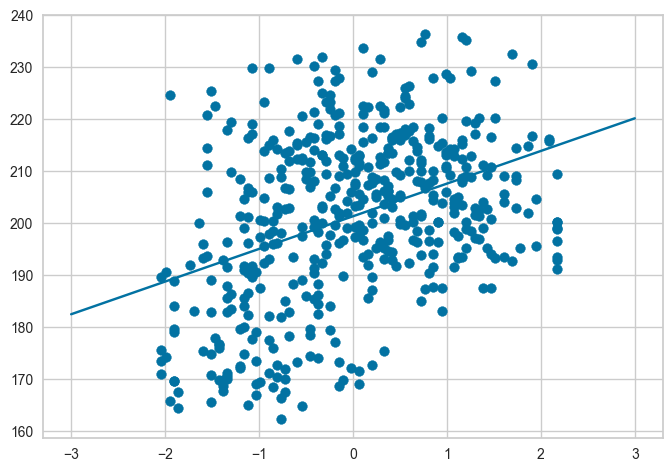

In [28]:
from sklearn.linear_model import LinearRegression

# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = np.array(data.age_scaled)[:, np.newaxis]
y = np.array(data.bounce_time)[:, np.newaxis]

# fit our model to the data
model.fit(x, y)

# and let's plot what this relationship looks like 
xfit = np.linspace(-3, 3, 1000)
yfit = model.predict(xfit[:, np.newaxis])
plt.scatter(x, y)
plt.plot(xfit, yfit);

We can have a look at these parameters within the model object, with the relevant parameters being ``coef_`` and ``intercept_``:

In [29]:
print("Model slope:    ", model.coef_[0])
print("Model intercept:", model.intercept_)

Model slope:     [6.27960201]
Model intercept: [201.31646152]


In [33]:
# and let's store the rmse
y_predict = model.predict(x)
RMSE = sqrt(((y-y_predict)**2).mean())

results = pd.DataFrame()
results["Method"] = ["Linear Regression"]
results["RMSE"] = RMSE
results

,Method,RMSE
0,Linear Regression,14.928334


So from this we would say quite confidently that as age increases so does the bounce time. (To test if this increase is significant see take-home challenge 1 in the [Kaggle notebook](https://www.kaggle.com/ojwatson/mixed-models/comments).)

However, to run a linear regression a number of assumptions about the data need to be met. One of these is that the residuals are **homoscedastic**, which means that the residuals are normally distributed relative to the predicted value with variance that does not vary across different values of the independent variable(s), i.e., our predictions are equally bad (or good) across our predicted values. We can look at this by plotting the residuals, using my new favorite package yellowbrick:

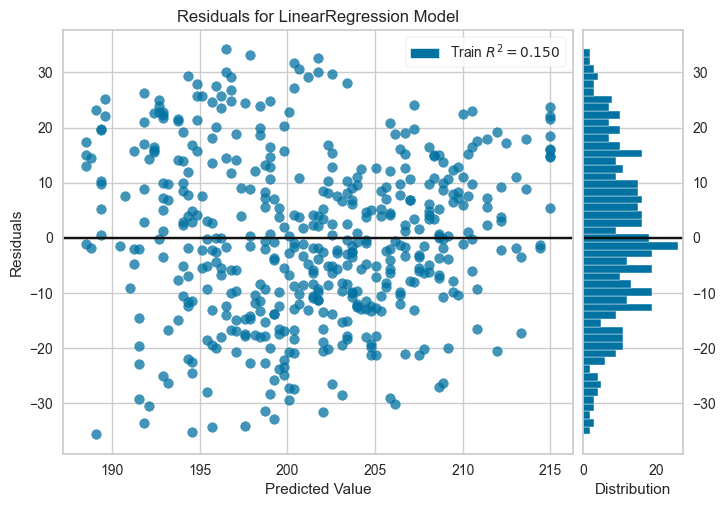

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [37]:
#!conda install -c districtdatalabs yellowbrick
import yellowbrick
from sklearn.linear_model import Ridge
from yellowbrick.regressor import ResidualsPlot

# Instantiate the linear model and visualizer
visualizer = ResidualsPlot(model)

visualizer.fit(x, y)  # Fit the training data to the model
visualizer.poof()                    # Draw/show/poof the data

Actually not toooooo bad - you could say that there are more positive residuals than negative residuals at the highest and lowest predicted value ranges, e.g., predicted value < 195, and >210 there are more positive residuals than negative. You can have a look at this also using seaborn's `residplot`:

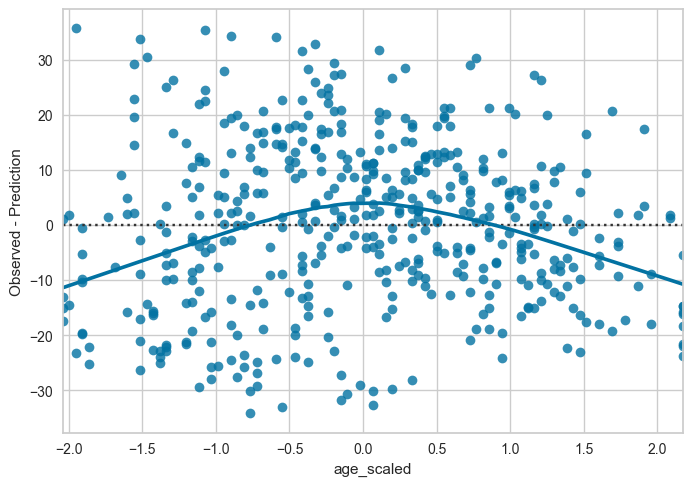

In [38]:
ax = sns.residplot(x = "age_scaled", y= "bounce_time", data = data, lowess = True)
ax.set(ylabel='Observed - Prediction')
plt.show()

Okay, so perhaps it's not ideal.

Let's check some of the other assumptions. For a good list of the assumptions (with code in R), have a look [here](http://r-statistics.co/Assumptions-of-Linear-Regression.html). 

One of the other key assumptions is that the observations of our data are independent of the other data. When we collected our data we were doing it in 8 different counties and in 3 locations within each county. So we could check this by comparing the bounce times for each county. To do this let's use one of the categorical plots in seaborn:

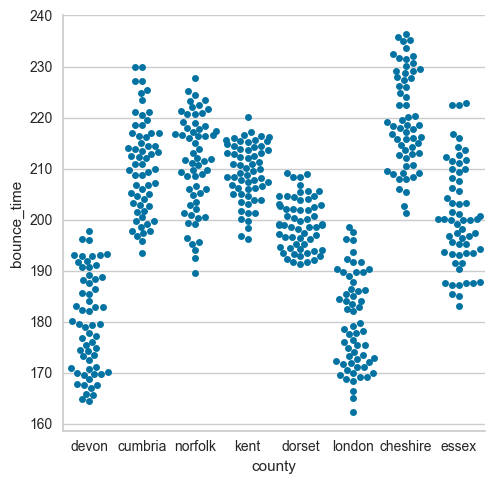

In [39]:
sns.catplot(x="county", y="bounce_time", data=data, kind = "swarm")

Ah, clearly there is substantial grouping --- us Londoners seem to have short attention spans (maybe). So we can definitely say that our data are not independent, and thus it is inappropriate to use a linear model for these data. 

What next? Well maybe we could do a separate regression for each county.

## Separate Linear Regression

Same as before, we are going to fit a linear regression to the data, but first separating it by county. Mathematically, this now looks like:

$$
time_c = b_{c0} + b_{c1}age
$$

where the subscript *c* here represents the county. As a result we will be estimating 8 different intercept and 8 different gradients, one for each county. Let's have a look at that using the facet grid options within `sns.lmplot`.

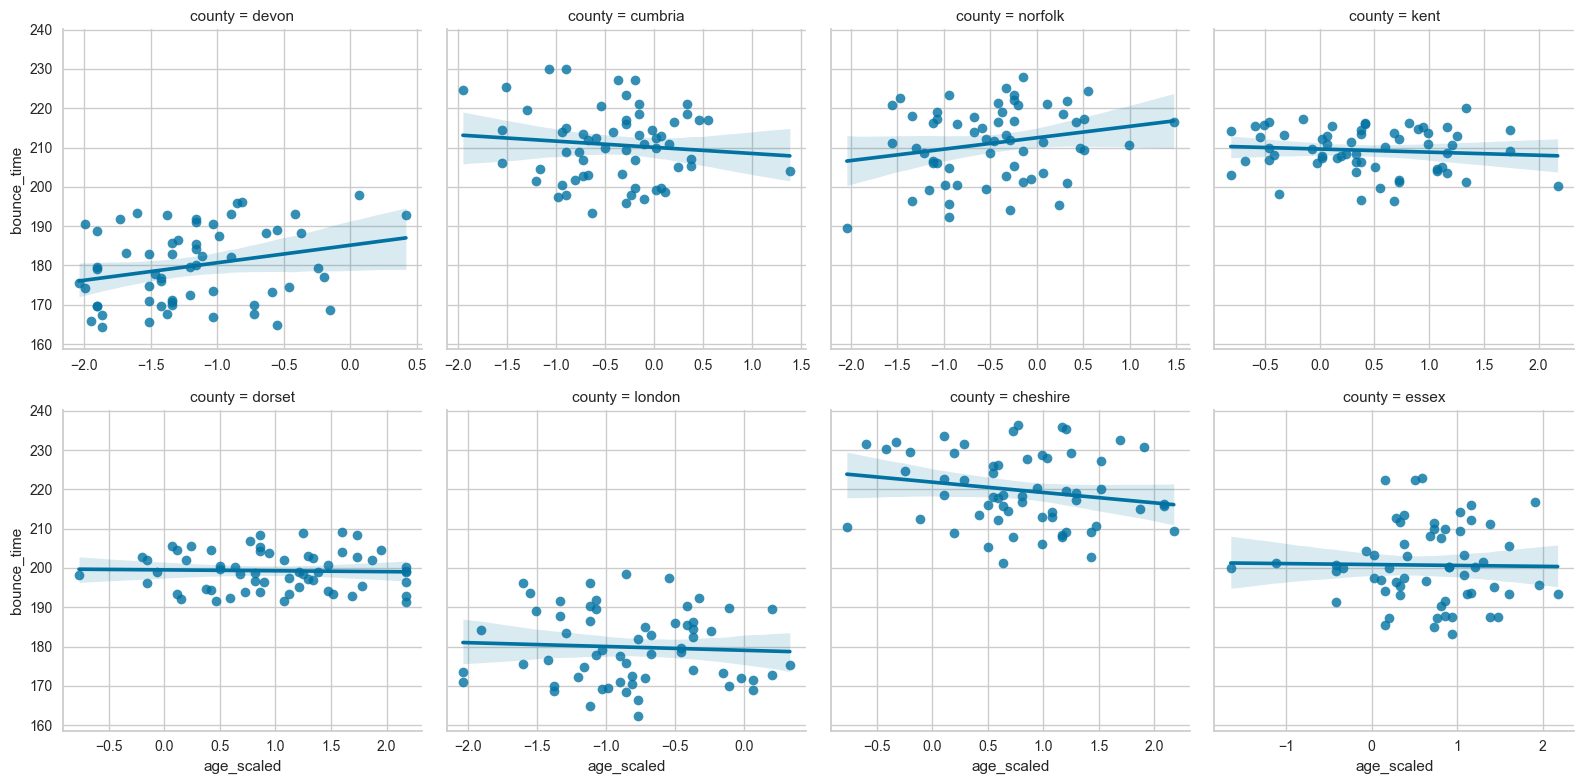

In [40]:
# let's use the lmplot function within seaborn
grid = sns.lmplot(x = "age_scaled", y = "bounce_time", col = "county", sharex=False, col_wrap = 4, data = data, height=4)

So now we have 8 different analyses. This is fine, but we have started to reduce our sample size a lot already as a result, and we are now perhaps going too far in the other direction from what we did before. Before we were saying that all counties were identical, whereas here we are saying that the impact of `age` on `bounce_time` shares no similarity between counties, which is probably again not true.

In addition, what about our location variable? Maybe our data are also not independent when looking at location. Let's have a look at this too, using a swarm plot:

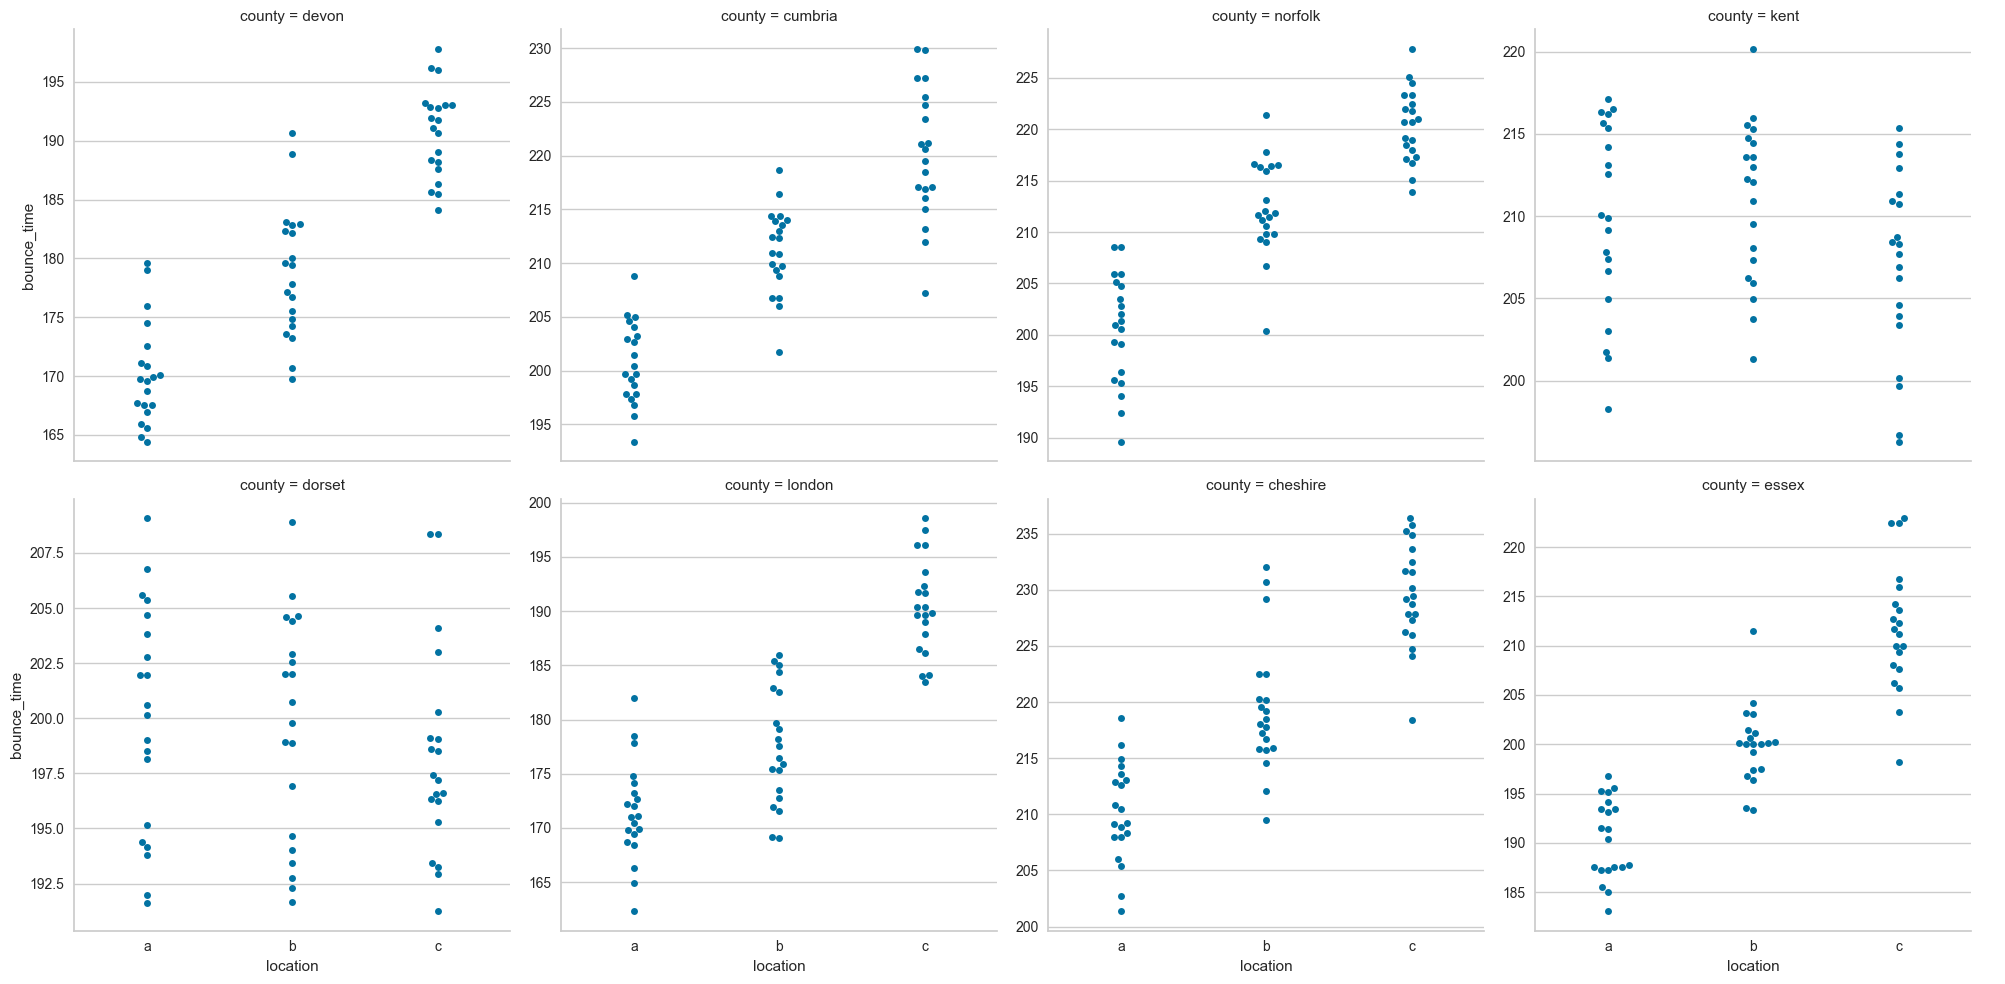

In [41]:
sns.catplot(x="location", y="bounce_time", col="county", col_wrap=4, sharey=False, data=data, kind = "swarm")

So, we could carry on and then do an individual regression for each location within each county. Hopefully you can see why we can't always just do an individual regression for each new group. If we did we would have to to estimate a slope and intercept parameter for each regression. That’s two parameters, three locations and eight counties, which means 48 parameter estimates (2 x 3 x 8 = 48). 

Also, we would now be taking our nice dataset of 480 observations, that presumably took a long time to collect, and effectively reducing it to lots of sample sizes of 20. This really decreases our statistical power, and thus also increases our chances of a Type I Error (where you falsely reject the null hypothesis) by carrying out multiple comparisons.

So what could we do? Well we could modify the model to account for the different counties, and add it to our linear model.

___
## Modelling county as a fixed effect

One way to incorporate the impact of county is to bring the county into our equation for the linear model by treating it as a fixed effect. This would look like: 

$$
time_{c_{i}} = b_{0} + b_{1}age + c_i
$$

i.e., each county has its own additional term that will change the intercept. To model this we will need to alter our dataframe to encode our counties as numeric variables. So we will use **one-hot encoding**, where we will make a new column for each county:

In [42]:
# make a new data frame with one hot encoded columns for the counties
counties = data.county.unique()
data_new = pd.concat([data,pd.get_dummies(data.county)],axis=1)
data_new.head()

,bounce_time,age,county,location,age_scaled,cheshire,cumbria,devon,dorset,essex,kent,london,norfolk
0,165.548520,16,devon,a,-1.512654,False,False,True,False,False,False,False,False
1,167.559314,34,devon,a,-0.722871,False,False,True,False,False,False,False,False
2,165.882952,6,devon,a,-1.951423,False,False,True,False,False,False,False,False
3,167.685525,19,devon,a,-1.381024,False,False,True,False,False,False,False,False
4,169.959681,34,devon,a,-0.722871,False,False,True,False,False,False,False,False


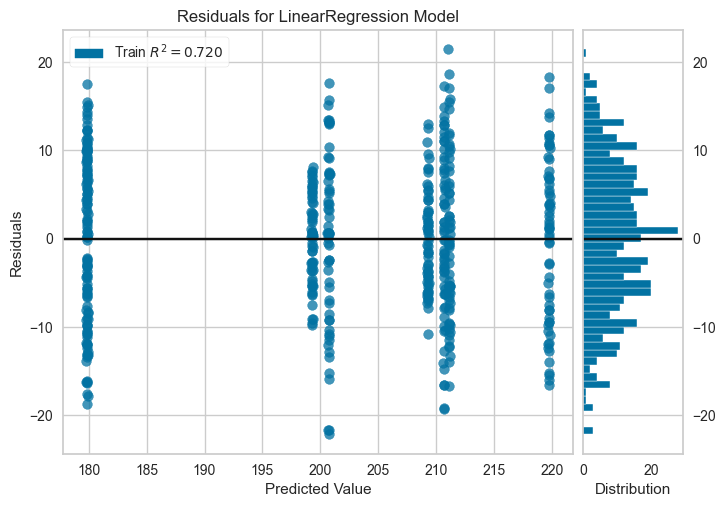

<Axes: title={'center': 'Residuals for LinearRegression Model'}, xlabel='Predicted Value', ylabel='Residuals'>

In [43]:
# construct our linear regression model
model = LinearRegression(fit_intercept=True)
x = data_new.loc[:,np.concatenate((["age_scaled"],counties))]
y = data.bounce_time

# fit our model to the data
model.fit(x, y)

# and let's plot what this relationship looks like 
visualizer = ResidualsPlot(model)
visualizer.fit(x, y)  # Fit the training data to the model
visualizer.poof()  

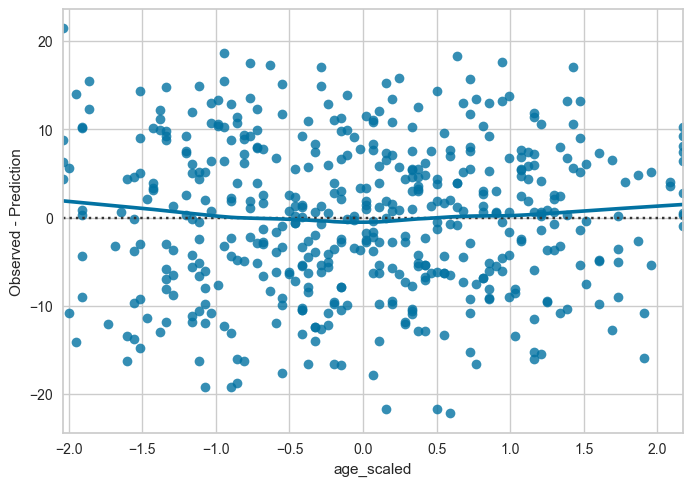

In [44]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = model.predict(x) - data.bounce_time
performance["age_scaled"] = data.age_scaled
performance["predicted"] = model.predict(x)

ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

The residuals are much better than before, being more evenly distributed with respect to age, and if we look at the predictions within each county:

(200.0, 202.0)

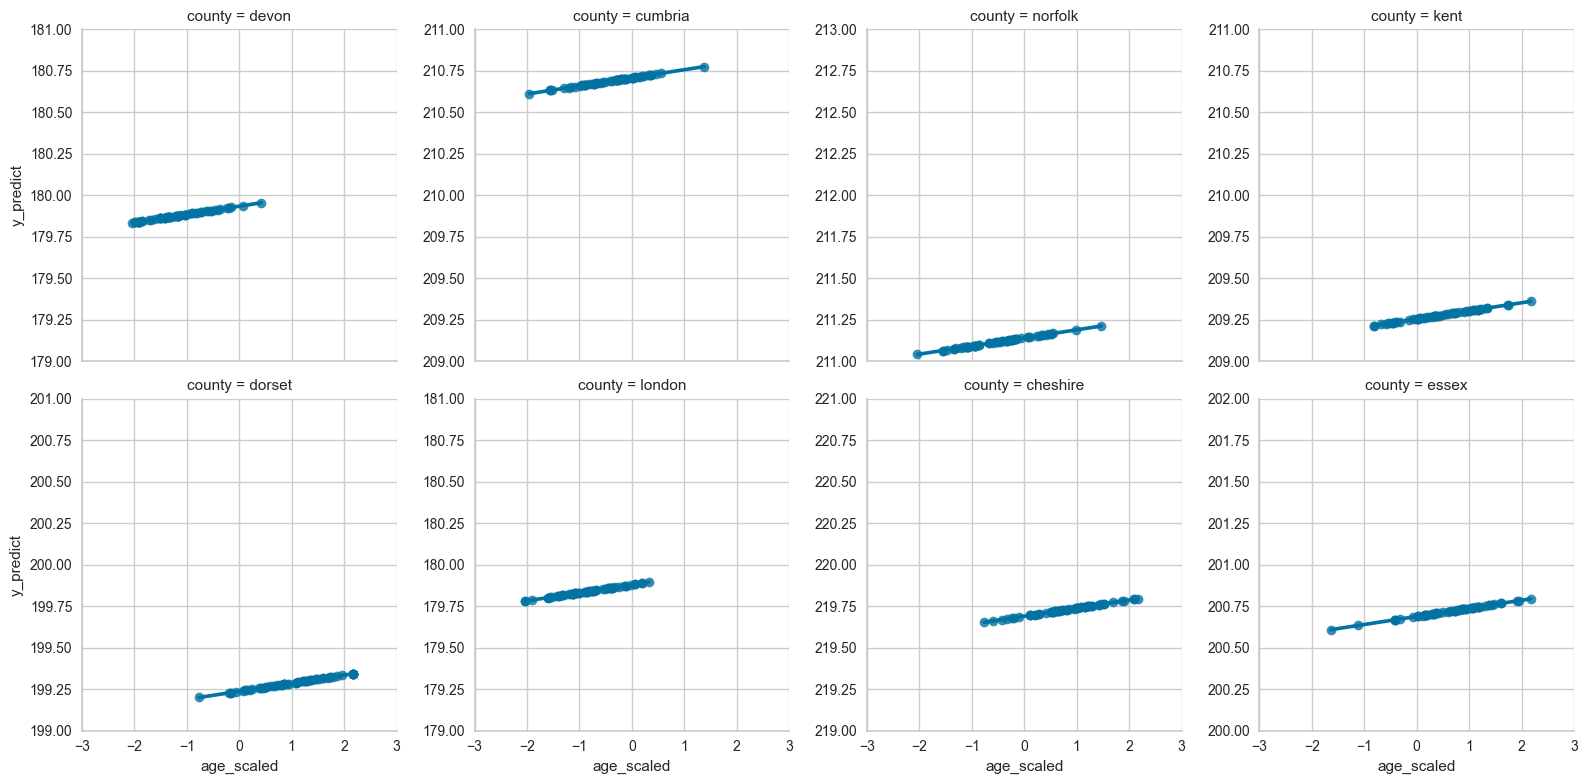

In [45]:
data_new["y_predict"] = model.predict(x)
grid = sns.lmplot(x = "age_scaled", y = "y_predict", col = "county", sharey=False, col_wrap = 4, data = data_new, height=4)
grid.set(xlim=(-3,3))
grid.axes[0].set_ylim(179,181)
grid.axes[1].set_ylim(209,211)
grid.axes[2].set_ylim(211,213)
grid.axes[3].set_ylim(209,211)
grid.axes[4].set_ylim(199,201)
grid.axes[5].set_ylim(179,181)
grid.axes[6].set_ylim(219,221)
grid.axes[7].set_ylim(200,202)

In [46]:
# and let's store the rmse
y_predict = model.predict(x)
RMSE = sqrt(((y-y_predict)**2).mean())
results.loc[1] = ["Fixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396


Now we can see that the coefficient for the gradient given to age is substantially smaller, and is likely no longer significant. Note that in the plots above, the $y$-axis ranges are all the same so that you can see that all the slopes are the same (this model forces a common slope), but the $y$-axis ranges are all different (counties differ in average bounce time). Let's just check that by making a table of the coefficients:

In [47]:
# coefficient for age and the counties
pd.DataFrame.from_records(list(zip(np.concatenate((["age_scaled"],counties)), model.coef_)))

,0,1
0,age_scaled,0.048782
1,devon,-21.381957
2,cumbria,9.391460
3,norfolk,9.824419
4,kent,7.938668
5,dorset,-2.079637
6,london,-21.437323
7,cheshire,18.372916
8,essex,-0.628546


But what model have we actually fitted here? Is it what we wanted to investigate initially? The  model is estimating the difference in bounce times between the counties now as well, and we aren't actually interested in that. If you were, then this is correct thing to do, but the website company just wanted to know whether age affects the bounce times. And by including county in the analysis we are obscuring this. So to look at the impact of age on bounce times we need to control for the variation between the different counties (as well as between the locations). So to do that, we have to treat our counties as **random effects**, and build a **mixed-effects model**!

## Mixed-effects models

As we have discussed above, a mixed-effects model is ideal here as it will allow us to both use all the data we have (higher sample size) and better acknowledge the correlations between data coming from the counties and locations. We will also estimate fewer parameters and avoid problems with multiple comparisons that we would encounter while using separate regressions.

So in this model we treat our `age`, which is what we are interested in, as a **fixed effect**, and `county` and `location` as a **random effect**.

But what does that mean? Well it's sort of a middle ground here between assuming our coefficient for the gradient and intercept are all the same (what we did in the first regression) and assuming they are all independent and different. If we look back at our equations, we now may assume that while $b_0$ and $b_1$ are different for each county, the coefficients all come from a common group distribution, such as a normal distribution:

$$
\begin{align*}
time_c = b_{c0} + b_{c1}.age  \\ \\
b_{c0} \sim N(\mu_{b_0}, \sigma^2_{b_0}) \\
b_{c1} \sim N(\mu_{b_1}, \sigma^2_{b_1})
\end{align*}
$$

So we now assume the intercepts $b_0$ and gradients $b_1$  come from a normal distribution centered around their respective group mean $\mu$ with a certain standard deviation $\sigma^2$, the values of which we also estimate.

### Fixed vs random?

So what makes a variable a fixed or random effect. Hmmm, it's tricky and there are lots of answers out there. In brief, we view fixed effects as the variables that we are interested in. We wanted to know about age so we recorded data on that and wanted to see how it impacted the response variable. County was not what we were interested in, but we recorded it as we were aware that our sampling methodology could lead to clustering in our data that could invalidate the linear model from before. If we hadn't recorded that someone who was given this dataset to analyze may have incorrectly said that  age was an important predictor of bounce rate.

Random effects are often the groups we are trying to control for, like county in our example --- in particular to control for counties when we have not exhausted all the available groups --- we only had 8 counties in England. If we wanted to make predictions about the counties, then we would have tried to sample them better from the start, and also treat them as a fixed effect. 

Further reading for those who want a better answer [here](https://dynamicecology.wordpress.com/2015/11/04/is-it-a-fixed-or-random-effect/)!

And see the discussion in the paper linked in take-home challenge 3 in the [Kaggle notebook](https://www.kaggle.com/ojwatson/mixed-models/comments). 

### Fitting our mixed effect lm

We will now fit our model using the `statsmodels` library. In this initial model we will look at how the bounce time relates to the scaled ages, while controlling for the impact of counties by allowing for a random intercept for each country, i.e., we are saying that each county has its own random intercept but that the slopes are still the same with respect to age.

In [48]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

# construct our model, with our county now shown as a group
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"])
mdf = md.fit()
print(mdf.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: bounce_time
No. Observations: 480     Method:             REML       
No. Groups:       8       Scale:              74.7350    
Min. group size:  60      Log-Likelihood:     -1733.0397 
Max. group size:  60      Converged:          Yes        
Mean group size:  60.0                                   
---------------------------------------------------------
             Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
---------------------------------------------------------
Intercept   201.316    5.175 38.902 0.000 191.174 211.459
age_scaled    0.136    0.612  0.221 0.825  -1.065   1.336
Group Var   212.999   13.382                             



In this summary of the model, we can clearly see that the `age_scaled` is having a more noticable impact than in the fixed model earlier (coefficient of 0.136 rather than 0.048), however, importantly it is still not significantly different to 0, with the 95% interval for this coefficient spanning -1.065 - 1.336.

And let's look at the predictions.

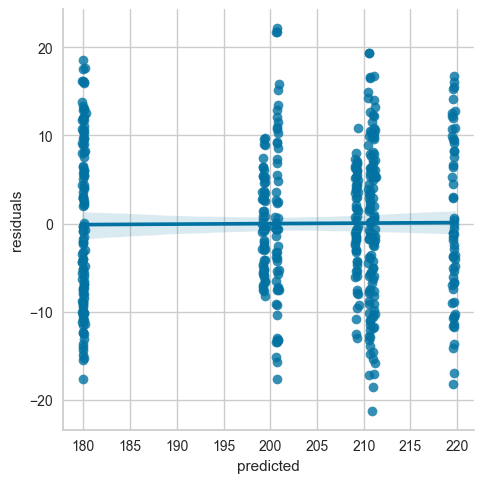

In [49]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

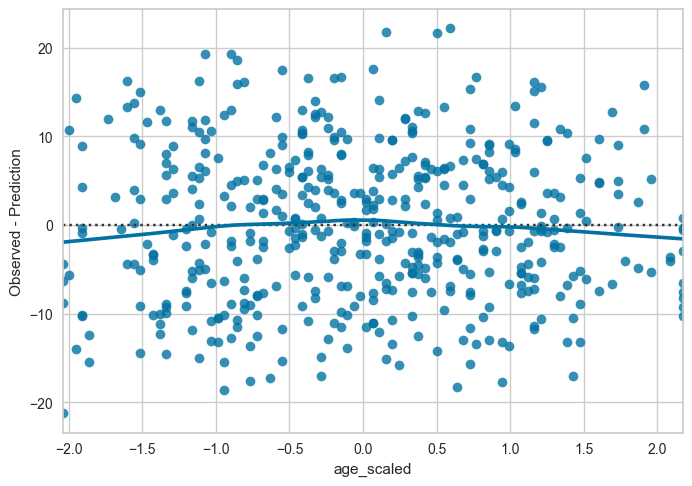

In [50]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [52]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).mean())
results.loc[2] = ["Mixed", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948


Huh, that's strange; it's very similar. In fact the residuals plot looks alomst identical to the previous one where we were treating the county as a fixed effect. Why? 

Well, we have to think about what we have actually just implemented. All we have done is say in the last one that the county has a random intercept, but the same slope. This is very similar to the fixed-effect approach, where county was included as a term that would impact the intercept. All we have changed is that we are now saying that the intercepts for each county are probably drawn from a similar distribution. To ensure that each county has its own random slope we need to include this in our random-effects formula, like so:

In [53]:
# construct our model, but this time we will have a random interecept AND a random slope with respect to age
md = smf.mixedlm("bounce_time ~ age_scaled", data, groups=data["county"], re_formula="~age_scaled")
mdf = md.fit()
print(mdf.summary())

               Mixed Linear Model Regression Results
Model:                 MixedLM    Dependent Variable:    bounce_time
No. Observations:      480        Method:                REML       
No. Groups:            8          Scale:                 72.8722    
Min. group size:       60         Log-Likelihood:        -1733.3946 
Max. group size:       60         Converged:             No         
Mean group size:       60.0                                         
--------------------------------------------------------------------
                        Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------
Intercept              202.140    8.356 24.190 0.000 185.762 218.518
age_scaled               0.161    1.196  0.134 0.893  -2.184   2.505
Group Var              558.143                                      
Group x age_scaled Cov -51.614                                      
age_scaled Var           8.621                    

/opt/miniconda3/envs/lab-in-cp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/lab-in-cp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  warnings.warn(
/opt/miniconda3/envs/lab-in-cp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/opt/miniconda3/envs/lab-in-cp/lib/python3.12/site-packages/statsmodels/regression/mixed_linear_model.py:2200: ConvergenceWarning: Retrying MixedLM optimization with cg
  warnings.warn(
/opt/miniconda3/envs/lab-in-cp/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimizatio

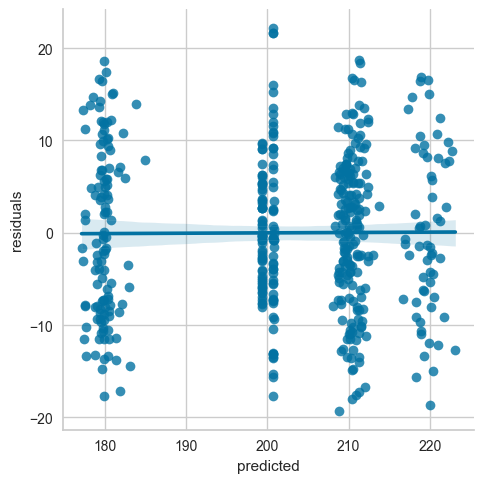

In [54]:
# and let's plot the predictions
performance = pd.DataFrame()
performance["residuals"] = mdf.resid.values
performance["age_scaled"] = data.age_scaled
performance["predicted"] = mdf.fittedvalues

sns.lmplot(x = "predicted", y = "residuals", data = performance)

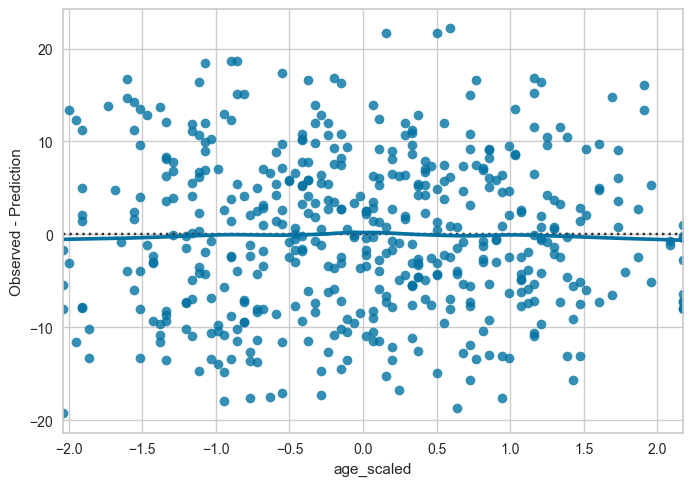

In [55]:
ax = sns.residplot(x = "age_scaled", y = "residuals", data = performance, lowess=True)
ax.set(ylabel='Observed - Prediction')
plt.show()

In [58]:
# and let's store the rmse
y_predict = mdf.fittedvalues
RMSE = sqrt(((y-y_predict)**2).mean())
results.loc[3] = ["Mixed_Random_Slopes", RMSE]
results

,Method,RMSE
0,Linear Regression,14.928334
1,Fixed,8.563396
2,Mixed,8.563948
3,Mixed_Random_Slopes,8.475248


---


So, our mixed model with the random slopes is now performing much better, with our residuals much better distributed. Crucially though, we can see that age does not impact the bounce rate, with the confidence intervals for the gradient with respect to age spanning -2.184 - 2.505 after we have controlled for the random variation caused by the county properly, i.e., with a random slope and intercept. 

```
--------------------------------------------------------------------------
                              Coef.  Std.Err.   z    P>|z|  [0.025  0.975]
--------------------------------------------------------------------------
Intercept                    202.140    8.356 24.190 0.000 185.762 218.518
age_scaled                     0.161    1.196  0.134 0.893  -2.184   2.505
Intercept RE                 558.143                              
Intercept RE x age_scaled RE -51.614                                 
age_scaled RE                  8.621                                      
==========================================================================
```

What we have seen in our data was that individuals in certain counties took longer on the website, and that they happened to also be old. However, to get to this distinction we had to first treat county as a random effect. But what about location? Eh? Forgot about that. See take-home material 4 in the [Kaggle notebook](https://www.kaggle.com/ojwatson/mixed-models/comments) for that one.